In [2]:
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math
from sklearn.model_selection import GridSearchCV,train_test_split,KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.feature_selection import SelectFromModel, RFE, RepeatedKFold, cross_validate
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, FunctionTransformer
from sklearn.ensemble import ExtraTreesClassifier
from category_encoders import OneHotEncoder 
from scipy.stats import skew
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipelin

C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [36]:
from category_encoders import OneHotEncoder 

In [3]:
house_ts = pd.read_csv(r'C:\Users\Rae-Djamaal\Anaconda3\Lib\Git_Uploads\house-prices-advanced-regression-techniques\test.csv',index_col=0)
house_tr = pd.read_csv(r'C:\Users\Rae-Djamaal\Anaconda3\Lib\Git_Uploads\house-prices-advanced-regression-techniques\train.csv',index_col=0)


**Exploratory Data Analysis**

In [4]:
# check shape of the train and test sets
print(house_ts.shape)
print(house_tr.shape)

# Separate the price from train set
y_tr = house_tr['SalePrice']
print(y_tr.shape)

(1459, 79)
(1460, 80)
(1460,)


Lets get the intersection of Train and test Dataframes since they may have some different columns

In [5]:
cols = house_tr.columns.intersection(house_ts.columns)

# Train shape and Length
house_tr = house_tr[cols]
print(house_tr.shape)
train_length = len(house_tr)

house_ts = house_ts[cols]
print(house_ts.shape)
test_length = len(house_ts)

(1460, 79)
(1459, 79)


## Concat both Dataframes Together to save time

In [6]:
# Concat the two dataframes
train_test = pd.concat([house_tr,house_ts],axis=0,sort=False)
print(train_test.shape)

(2919, 79)


#Now that I merged the Train and Test,here is a good place to talk about **Data Leakage**

I will go about separating the Train Set From the Test Set sometimes when doing the feature engineering. Doing this would reduce any potential Data Leakage in our model.

**Data leakage** is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed.

https://machinelearningmastery.com/data-leakage-machine-learning/

**Feature Selection**

* Vizualize a heatmap of the null values.Green indicates the amount of null values in the variable





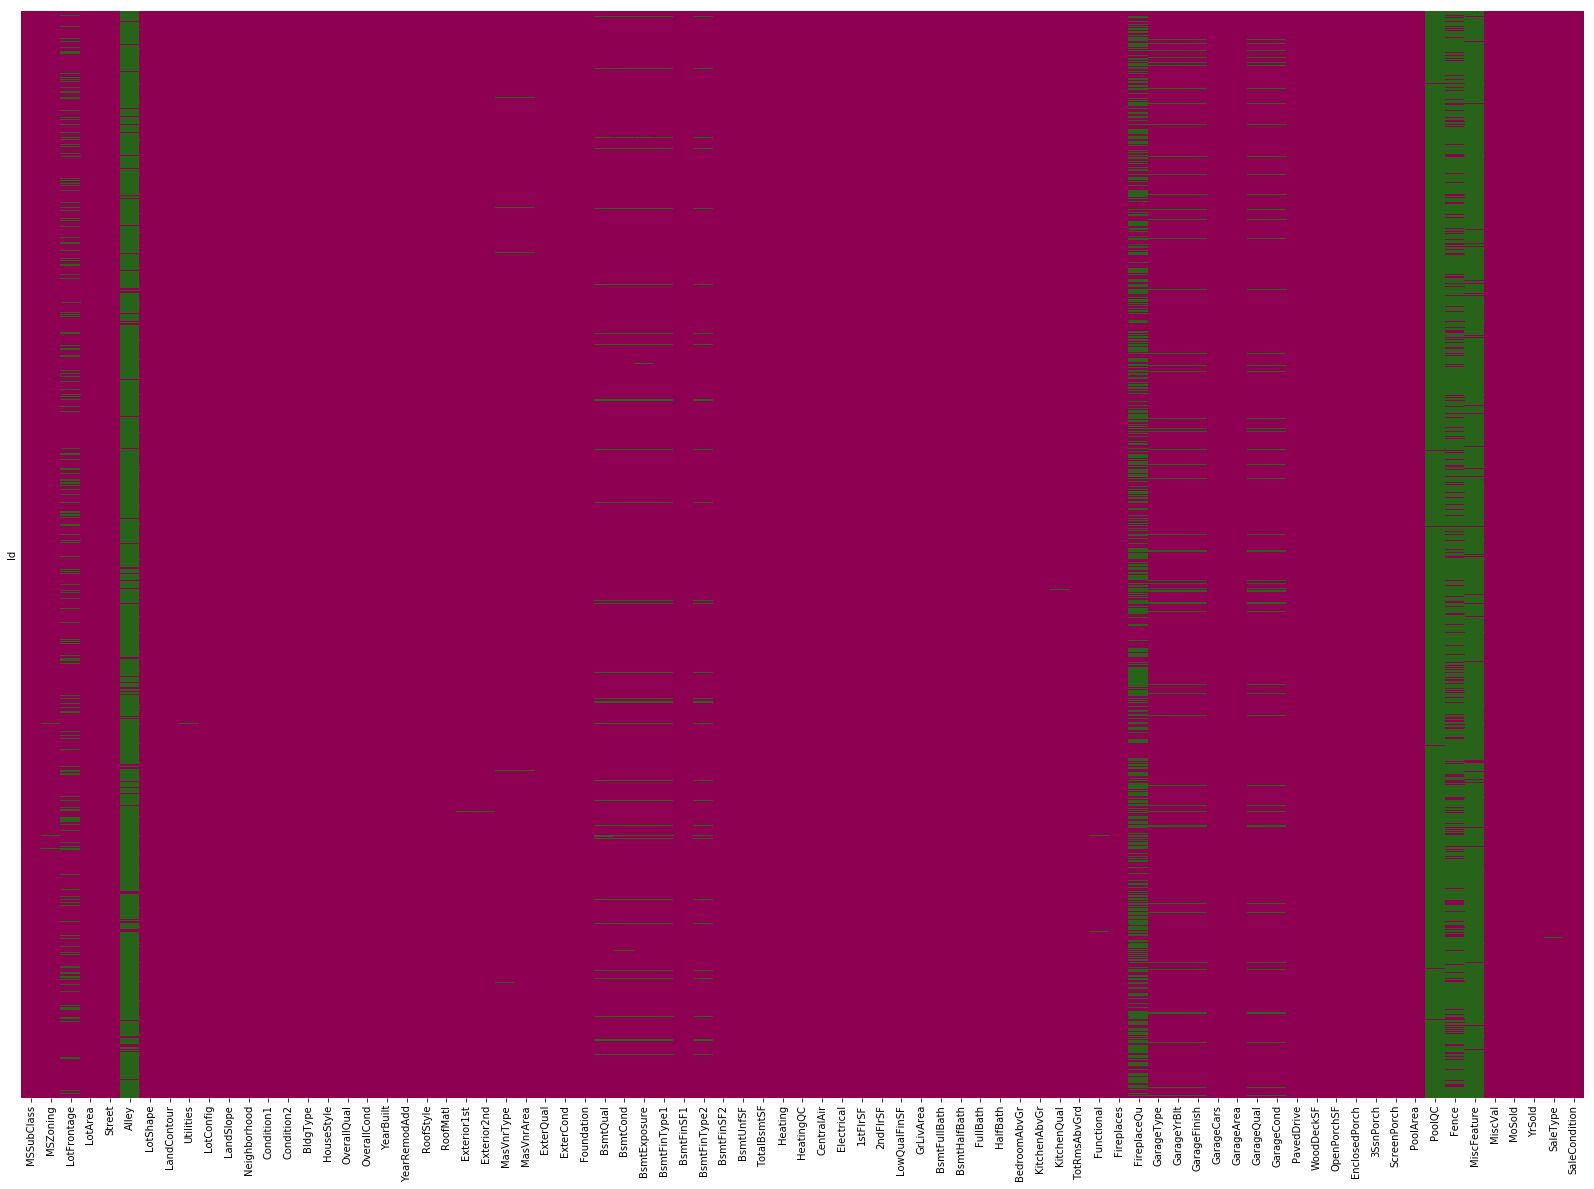

In [7]:
# Heatmap highlighting Null counts from train set
plt.figure(figsize = (28,20))
sns.heatmap(train_test.isnull(), yticklabels=False,cmap="PiYG", cbar=False)

**Feature Selection**
* Remove columns with Null Values > 50%**

In [8]:
# Check all features with more than half columns nans from test set
for column in train_test.columns:
  if train_test[column].isnull().sum()> len(train_test)/2:
    print(column)

# Delete these columns
train_test = train_test.dropna(thresh=len(train_test)/2,axis=1)
print('New Shape ',train_test.shape)

Alley
PoolQC
Fence
MiscFeature
New Shape  (2919, 75)


**Feature Engineering**
*   Separate Object types from Numeric types




In [9]:
# object datatypes for the joint datasets
obj_tr = train_test.select_dtypes(include=['object']).copy()
print(obj_tr.shape)

# numeric datatypes from the joint datasets
num_tr = train_test.select_dtypes(include=['int64','float64']).copy()
print(num_tr.shape)

(2919, 39)
(2919, 36)


Split train and test set to avoid Data Leakage


In [10]:
# Train Set
num_trn = num_tr.loc[0:train_length,:]
obj_trn = obj_tr.loc[0:train_length,:]

# Test Set
num_tst = num_tr.loc[train_length+1:,:]
obj_tst = obj_tr.loc[train_length+1:,:]

**Feature Engineering**

Replace all remaining null values with the median for the numeric train and numeric test sets.

Mode and Mean are options as well depending on your data


In [11]:
# Replace numeric nans with zero in the train set
tr_num_nan=[feature for feature in num_trn.columns if num_trn[feature].isnull().sum()>=1 and num_trn[feature].dtypes!='O']
for feature in tr_num_nan:
    # num_tr[feature].fillna(0,inplace=True)
  
    ## We will replace by using median since there are outliers
    median_value=num_trn[feature].median()
    num_trn[feature].fillna(median_value,inplace=True)

# Count null in train set 
num_trn[tr_num_nan].isnull().sum()

# Replace numeric nans with zero in the test set
tr_num_nan=[feature for feature in num_tst.columns if num_tst[feature].isnull().sum()>=1 and num_tst[feature].dtypes!='O']
for feature in tr_num_nan:
  
    ## We will replace by using median since there are outliers
    median_value=num_tst[feature].median()
    num_tst[feature].fillna(median_value,inplace=True)

# Count null in test set 
num_tst[tr_num_nan].isnull().sum()

C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

**Feature Engineering-Data Transformations**

Here I will **re-merge** the Train and Test **numeric dataframes** since final Data Transformations will take place in the modeling phase.Transformations Prior to modeling are for Illustration purpuses.Doing them in the modeling phase is to reduce **Data Leakage**. Some of the data transformations to come include: PowerTransformer, MinMaxScaler, StandardScaler, RobustScaler etc.

In [12]:
num_tr_ts = pd.concat([num_trn,num_tst],axis=0,sort=False)
print(num_tr_ts.shape)

(2919, 36)


**Skewness in Independent Variables**



![Skewness](https://lh3.google.com/u/0/d/1XD_72DoPo_5srmi3U40S4bApoxRGLLmk=k)




Check Skewness in the Independent features.Skewness is a measure of lack of symmetry.Thus skewness reduces the linear relationship between the predictor variables and the repsonse variable.

More about when and when not to Transform independent variables in this blog:
https://www.researchgate.net/post/Should_I_transform_non-normal_independent_variables_in_logistic_regression

In [13]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

numeric_features = list(num_tr_ts.columns)

#Absolute Skewness of features
from scipy.stats import skew
skewed_features = num_tr_ts[numeric_features].apply(lambda x: abs(skew(x))).sort_values(ascending=False)
print(skewed_features)
  

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.672470
1stFlrSF          1.469604
BsmtFinSF1        1.425407
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162619
BsmtUnfSF         0.919715
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
YearBuilt         0.599806
OverallCond       0.570312
YearRemodAdd      0.451020
GarageYrBlt       0.401842
BedroomAbvGr      0.326324
GarageArea        0.241184
GarageCars        0.218593
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
YrSold            0.132399
dtype: float64


Get a list of the high skewed features,those with skewness >1

In [14]:
#test
high_skewness = skewed_features[skewed_features >= 1]
skewed_features = high_skewness.index

**Data Vizualization**

* Regression Plots of each skewed feature with the target variable,SalePrice, 
before applying Transformations.






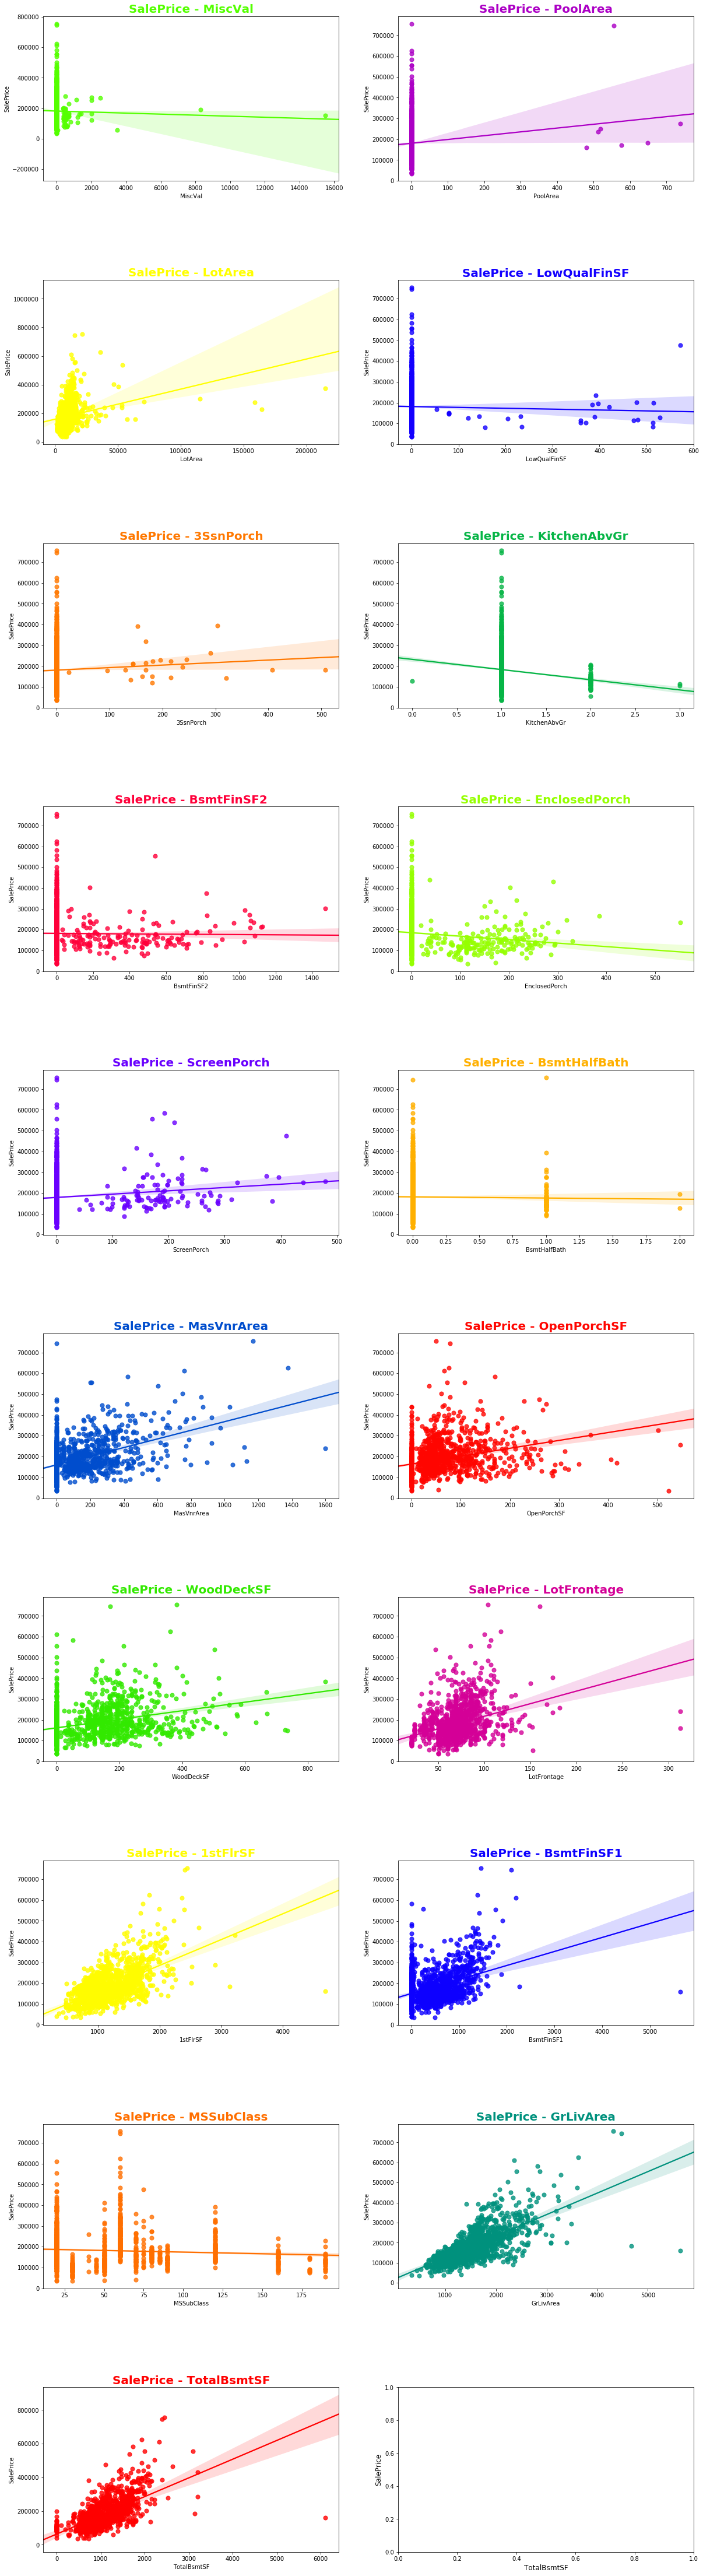

In [15]:
# skewed features Train set
num_tr_tsk = num_tr_ts[list(skewed_features)]
num_tr_tsk = num_tr_tsk.iloc[0:train_length,:]

# plt.style.use('dark_background')
fig, axes = plt.subplots(10, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(num_tr_tsk.columns))]
for i,ax,color in zip(num_tr_tsk,axes.flatten(),colors):
    sns.regplot(x=num_tr_tsk[i], y= y_tr, fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

**Analysis of Results before Transformation**

'MiscVal', 'PoolArea', 'LowQualFinSF', 'KitchenAbvGr', '3SnsPorch', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch' all have data that is clumped up together and thus these can be classified. Lets wait till we Transform them to see the results after**


Distribution Plot of Skewed features

C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


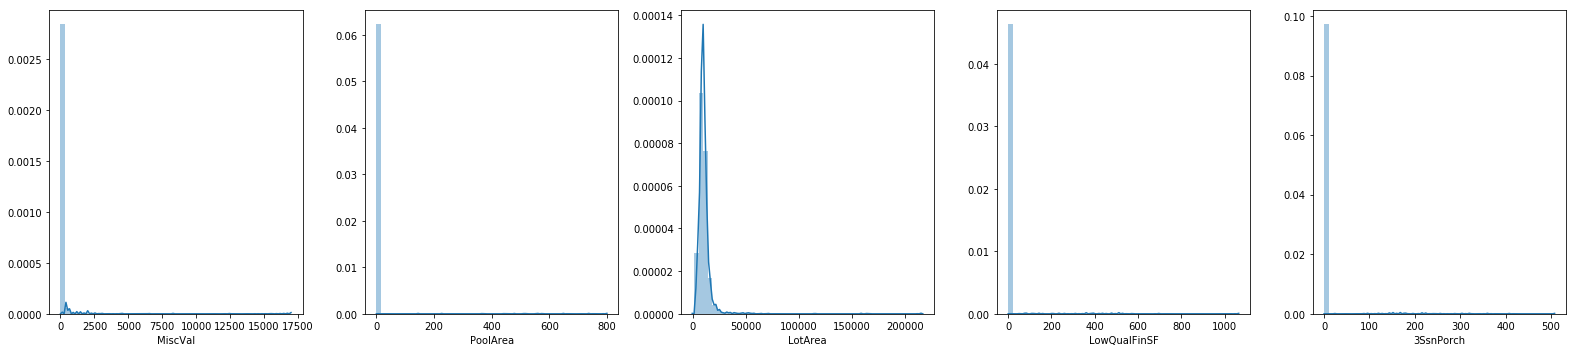

In [16]:
# Create the dataframe of top 5 most skeweed features for Vizualization
top_5 = list(skewed_features)[0:5]
top_5sk = num_tr_ts.loc[:,top_5]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(22,5))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  sns.distplot(top_5sk.iloc[:, i], ax=ax)

fig.tight_layout()

# # plot the top 4 skewed features before
# fig, ax=plt.subplots(1,2,figsize=(20,5))
# sns.distplot(num_tr_ts['MiscVal'], ax=ax[0])
# sns.distplot(num_tr_ts['PoolArea'], ax=ax[1])
# sns.distplot(num_tr_ts['LotArea'], ax=ax[2])
# sns.distplot(num_tr_ts['LowQualFinSF'], ax=ax[3])

**Note Again Scaling is only for Illustration Purposes,final scaling wil be done in the modeling section**

Apply a **PowerTransformer** to the Skewed data

Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like and thus **minimize skewness**.We will use the default distribution given more on powertransformer below

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html

In [17]:
# Apply a Power Transformer since power transformers are good at reducing Heteroskedacity
num_unskwed = PowerTransformer(method='yeo-johnson').fit_transform(num_tr_ts[list(skewed_features)])
num_unskw = pd.DataFrame(num_unskwed,columns=list(skewed_features))

C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Check the reduced Skewness

In [18]:
numeric_after = list(num_unskw.columns)

skewed_after = num_unskw[numeric_after].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_after)

PoolArea         14.884318
3SsnPorch         8.712332
LowQualFinSF      8.365937
MiscVal           5.037498
BsmtHalfBath      3.707260
ScreenPorch       2.915215
BsmtFinSF2        2.355271
EnclosedPorch     1.883152
MasVnrArea        0.457330
LotFrontage       0.174750
WoodDeckSF        0.135788
TotalBsmtSF       0.117419
MSSubClass        0.070346
GrLivArea         0.000000
1stFlrSF          0.000000
LotArea           0.000000
OpenPorchSF      -0.026061
BsmtFinSF1       -0.401346
KitchenAbvGr     -2.063585
dtype: float64


Visualize the distribution of the target variable SalePrice

We see that the normality assumptions do not hold here saleprice is nor normally distributed and can assume all of the other assumptions fail as well


C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

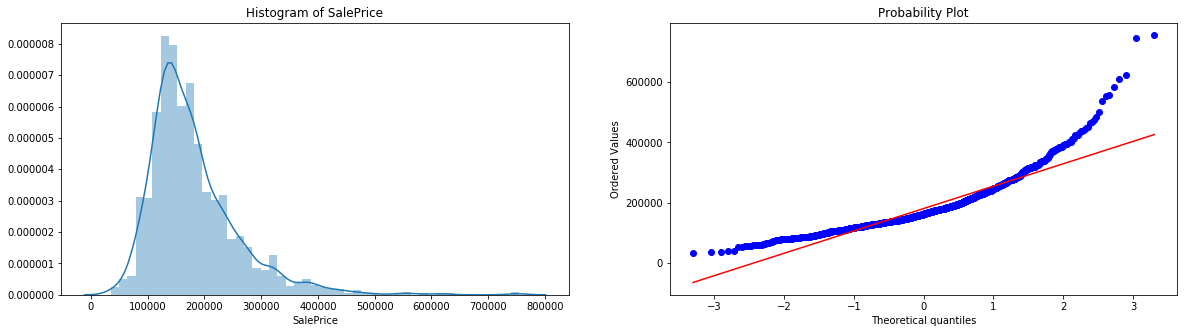

In [19]:
from scipy import stats
fig, ax=plt.subplots(1,2,figsize=(20,5))
ax[0].set_title('Histogram of SalePrice')
sns.distplot(y_tr, ax=ax[0])

ax[1].set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
stats.probplot(y_tr, plot=ax[1])

Now Apply a log Transformation to SalePrice and Vizualize the Reshaped Distribution

C:\Users\Rae-Djamaal\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.39825964665415087, 12.024057394918403, 0.99537615518267))

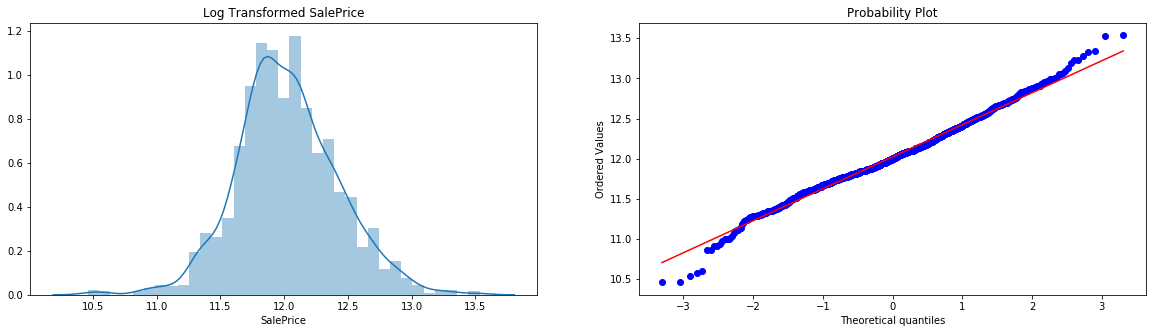

In [20]:
fig, ax=plt.subplots(1,2,figsize=(20,5))

ax[0].set_title('Log Transformed SalePrice')
sns.distplot(np.log1p(y_tr), ax=ax[0])

stats.probplot(np.log1p(y_tr), plot=ax[1])

**Data Vizualization**

Regression Plots after transformation to both Dependent and Independen Variables

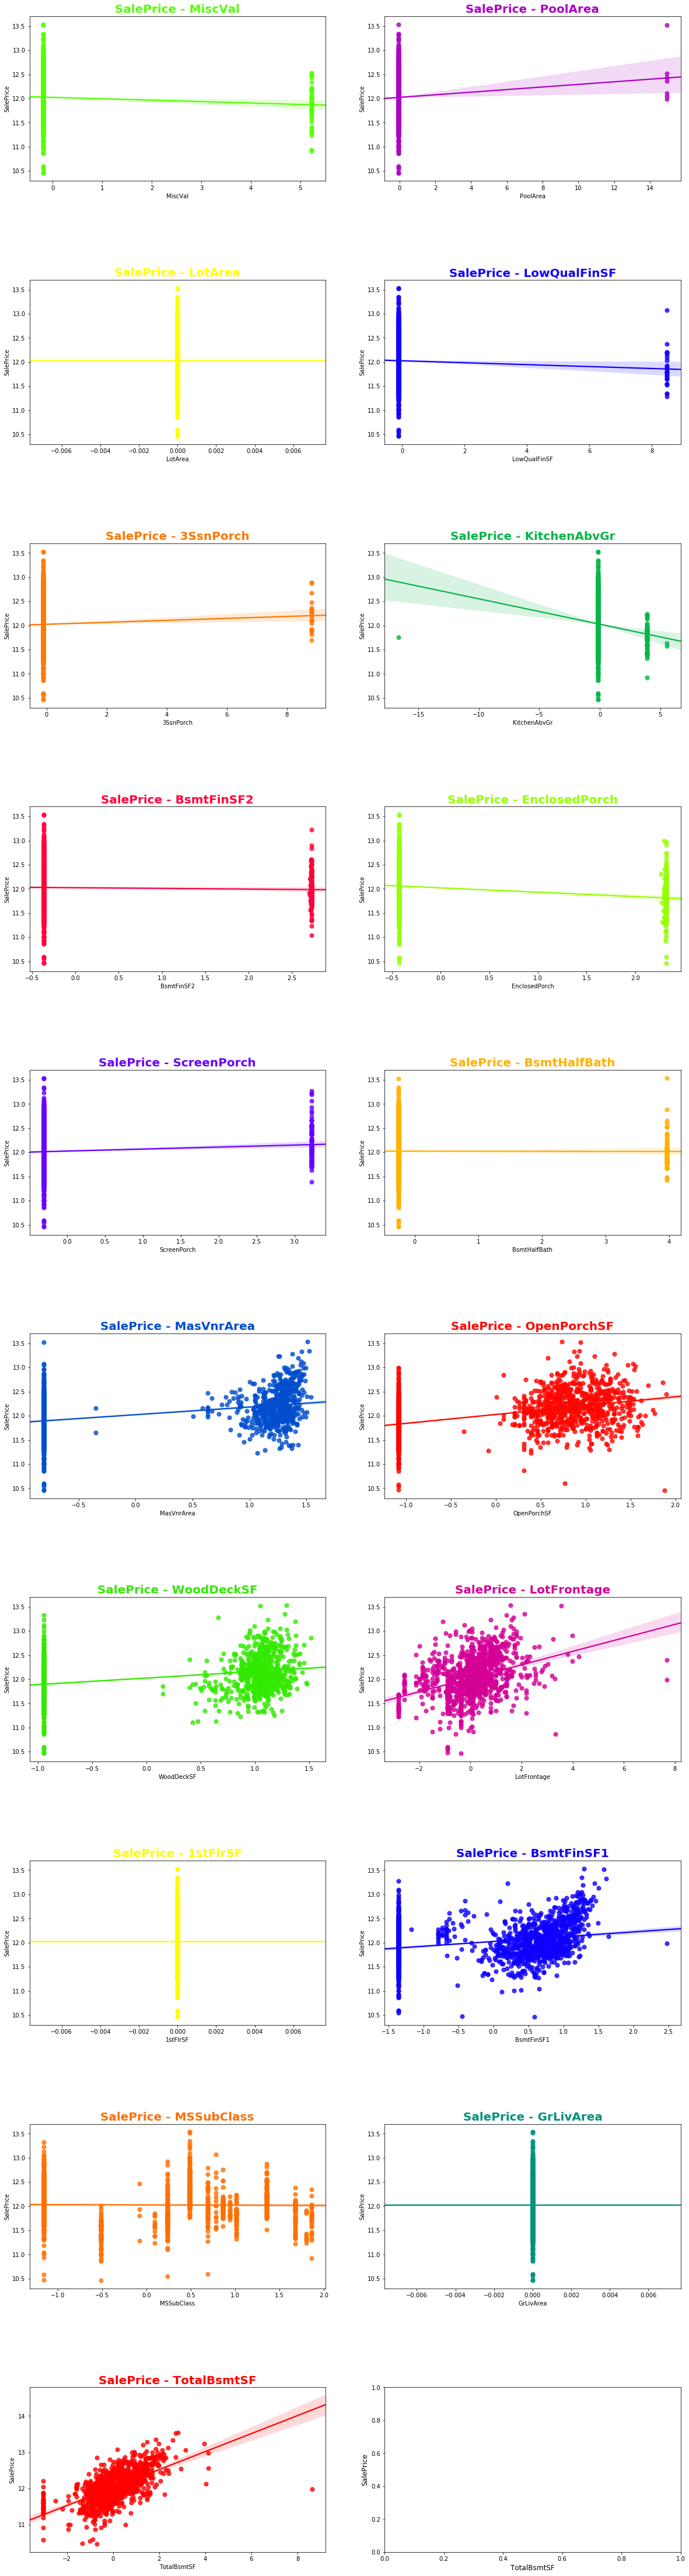

In [21]:
# Unskwed features Train set
num_unskw_Tr = num_unskw.iloc[0:train_length,:]

# plt.style.use('dark_background')
fig, axes = plt.subplots(10, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(num_unskw_Tr.columns))]
for i,ax,color in zip(num_unskw_Tr,axes.flatten(),colors):
    sns.regplot(x=num_unskw_Tr[i], y= np.log1p(y_tr), fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    # ax.set_yticks(np.arange(-100000,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

**Analysis after Transformation**

MiscVal', 'PoolArea', 'LowQualFinSF', 'KitchenAbvGr', '3SnsPorch', 'BsmtHalfBath', 'BsmtFinSF2', 'EnclosedPorch' all still have high skewness because they can be classified we will apply another Transformation to these.

Apply A Min Max Scaler to these variables that still have high skewness

In [22]:
from sklearn.preprocessing import MinMaxScaler

skew_over_1 = num_unskw[['PoolArea','KitchenAbvGr','3SsnPorch','BsmtHalfBath','BsmtFinSF2','LowQualFinSF','EnclosedPorch']]
num_unskwed_MinMax = MinMaxScaler().fit_transform(skew_over_1 )
num_unskwed_MinMax = pd.DataFrame(num_unskwed_MinMax,columns=skew_over_1.columns)
num_unskwed_MinMax

,PoolArea,KitchenAbvGr,3SsnPorch,BsmtHalfBath,BsmtFinSF2,LowQualFinSF,EnclosedPorch
0,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.742385,0.0,1.0,0.0,0.0,0.000000
2,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.742385,0.0,0.0,0.0,0.0,0.999443
4,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
2914,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
2915,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
2916,0.0,0.742385,0.0,0.0,0.0,0.0,0.000000
2917,0.0,0.742385,0.0,1.0,0.0,0.0,0.000000


Lets Use Value_counts() to check how the data Looks after applying MinMaxScaler

In [23]:
print(num_unskwed_MinMax['PoolArea'].value_counts())
print(num_unskwed_MinMax['KitchenAbvGr'].value_counts())
print(num_unskwed_MinMax['3SsnPorch'].value_counts())
print(num_unskwed_MinMax['BsmtHalfBath'].value_counts())
print(num_unskwed_MinMax['BsmtFinSF2'].value_counts())
print(num_unskwed_MinMax['LowQualFinSF'].value_counts())
print(num_unskwed_MinMax['EnclosedPorch'].value_counts())

0.0    2906
1.0      13
Name: PoolArea, dtype: int64
0.742385    2785
0.924487     129
0.000000       3
1.000000       2
Name: KitchenAbvGr, dtype: int64
0.0    2882
1.0      37
Name: 3SsnPorch, dtype: int64
0.0    2744
1.0     171
1.0       4
Name: BsmtHalfBath, dtype: int64
0.000000    2572
0.999778       5
0.999523       5
0.999884       3
0.999470       3
            ... 
0.999922       1
0.999982       1
0.997013       1
0.999980       1
0.999940       1
Name: BsmtFinSF2, Length: 272, dtype: int64
0.0    2879
1.0      40
Name: LowQualFinSF, dtype: int64
0.000000    2460
0.997980      22
0.997509      13
0.998573      11
0.999055      10
            ... 
0.998936       1
0.998501       1
0.999747       1
0.999380       1
0.998355       1
Name: EnclosedPorch, Length: 183, dtype: int64


**Feature Engineering-Creating a custom Transformer**

Now Lets Create a Function to binarize the data.A value Less that 0.5 = 0 and greater than 0.5 = 1.

As you may have noticed from the values above,based on how the MinMaxScaler function Works,no values will be on the 'border' of 0 or 1.                                                
For example, there will be no values of 0.55 or 0.47. The closest I can see to the threshold of 0.5 from the printout above is around the 0.75 in the 'PoolArea' variable.

For more on custom Transformers: 
https://github.com/HCGrit/MachineLearning-iamJustAStudent/blob/master/PipelineFoundation/Pipeline_Experiment.ipynb

In [24]:
# Custom Transformer
from sklearn.base import BaseEstimator, TransformerMixin

class ExperimentalTransformer_2(BaseEstimator, TransformerMixin):
  # add another additional parameter, just for fun, while we are at it
  def __init__(self, feature_name):  
    # print('\n>>>>>>>init() called.\n')
    self.feature_name = feature_name

  def fit(self, X, y = None):
    # print('\n>>>>>>>fit() called.\n')
    return self

  def transform(self, X, y = None):
    # print('\n>>>>>>>transform() called.\n')
    X_ = X.copy() # creating a copy to avoid changes to original dataset
    # Function to Binarize the data
    X_[self.feature_name] = np.where(X_[self.feature_name] > 0.5, 1,0)
    return X_


Run the Custom Transformer

In [25]:
Transformed_df = ExperimentalTransformer_2(['PoolArea','KitchenAbvGr','3SsnPorch','BsmtHalfBath','BsmtFinSF2','LowQualFinSF','EnclosedPorch']).fit_transform(num_unskwed_MinMax)
Transformed_df

,PoolArea,KitchenAbvGr,3SsnPorch,BsmtHalfBath,BsmtFinSF2,LowQualFinSF,EnclosedPorch
0,0,1,0,0,0,0,0
1,0,1,0,1,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2914,0,1,0,0,0,0,0
2915,0,1,0,0,0,0,0
2916,0,1,0,0,0,0,0
2917,0,1,0,1,0,0,0


In [26]:
# x_y['SalePrice1'] = np.log1p(x_y.SalePrice)
# x_y['SalePrice2'] = np.expm1(x_y.SalePrice1)
# xy_stdScaler = StandardScaler().fit_transform(x_y[['SalePrice2']])
# xy_Scaler = StandardScaler().fit_transform(x_y[['SalePrice1']])

# fig, ax=plt.subplots(1,4,figsize=(20,5))
# sns.distplot(x_y['SalePrice1'], ax=ax[0])
# sns.distplot(x_y['SalePrice2'], ax=ax[1])
# sns.distplot(xy_stdScaler, ax=ax[2])
# sns.distplot(xy_Scaler, ax=ax[3])

Remerge the Train and Test Objects

In [27]:
train_test_obj = pd.concat([obj_trn,obj_tst],axis=0,sort=False)
print(train_test_obj.shape)

(2919, 39)


**Feature engineering Ordinal Variables**
*  Fill Nans

In [28]:
train_test_obj['MasVnrType']=train_test_obj['MasVnrType'].fillna('MissingMasVnrType')
train_test_obj['BsmtQual']=train_test_obj['BsmtQual'].fillna('MissingBsmtQual')
train_test_obj['BsmtCond']=train_test_obj['BsmtCond'].fillna('MissingBsmtCond')
train_test_obj['BsmtExposure']=train_test_obj['BsmtExposure'].fillna('MissingBsmtExposure')
train_test_obj['BsmtFinType1']=train_test_obj['BsmtFinType1'].fillna('MissingBsmtFinType1')
train_test_obj['BsmtFinType2']=train_test_obj['BsmtFinType2'].fillna('MissingBsmtFinType2')
train_test_obj['FireplaceQu']=train_test_obj['FireplaceQu'].fillna('MissingFireplaceQu')
train_test_obj['GarageType']=train_test_obj['GarageType'].fillna('MissingGarageType')
train_test_obj['GarageFinish']=train_test_obj['GarageFinish'].fillna('MissingGarageFinish')
train_test_obj['GarageQual']=train_test_obj['GarageQual'].fillna('MissingGarageQual')
train_test_obj['GarageCond']=train_test_obj['GarageCond'].fillna('MissingGarageCond')

**Feature engineering Ordinal Variables**
*  Converting Catergory text to Numbers

In [29]:
# Ordinal Features to numeric
cleanup_nums = {"Utilities":{"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
                "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 3},
                "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 3},
                "BsmtQual": {'MissingBsmtQual': 0,"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 4},
                "BsmtCond": {'MissingBsmtCond': 0,"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 4},
                "BsmtExposure":{'MissingBsmtExposure': 0,"Po": 1, "Fa": 2, "TA": 2, "Gd": 4},
                "BsmtFinType1":{'MissingBsmtFinType1': 0,"Unf": 1, "LwQ": 2, "Rec": 2, "BLQ": 3, "ALQ": 3,"GLQ":4},
                "BsmtFinType2":{'MissingBsmtFinType2': 0,"Unf": 1, "LwQ": 2, "Rec": 2, "BLQ": 3, "ALQ": 3,"GLQ":6},
                "HeatingQC":{"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 3},
                "CentralAir":{"N": 0, "Y": 1},
                "KitchenQual":{"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 3},
                "Functional":{'Sal':0,'Sev': 0,"Maj2": 1, "Maj1": 1, "Mod": 2, "Min2": 3, "Min1": 3,"Typ":4},
                "FireplaceQu":{'MissingFireplaceQu': 0,"Po": 1, "Fa": 2, "TA": 2, "Gd": 3, "Ex": 3},
                "GarageQual":{'MissingGarageQual': 0,"Po": 1, "Fa": 2, "TA": 2, "Gd": 3, "Ex": 3},
                "GarageCond":{'MissingGarageCond': 0,"Po": 1, "Fa": 2, "TA": 2, "Gd": 3, "Ex": 3}}

In [30]:
#Observe the values b4 as all objects
train_test_obj.dtypes.value_counts()

object    39
dtype: int64

In [31]:
# Apply the ordinal Encode
train_test_obj.replace(cleanup_nums,inplace=True)

In [32]:
# See the Ordinal Values after are now numeric
train_test_obj.dtypes.value_counts()

object     25
int64      11
float64     3
dtype: int64

In [33]:
train_test_obj.shape

(2919, 39)

In [34]:
# Ordinal features only
obj_tr_tst_ordinal = train_test_obj.select_dtypes(include = ['int64','float64'])

**One hot encode categorical variables**

A one hot encoding is a representation of categorical variables as binary vectors. Many machine learning algorithms cannot work with categorical data directly,such as our Linear Regression. The categories must be converted into numbers. This is required for both input and output variables that are categorical.

For More on this: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

In [37]:
# one hot encoding for nominal variable
obj_1h_tr_ts = train_test_obj.select_dtypes(include=['object']).copy()

myEncoder = OneHotEncoder(handle_unknown='ignore')

codestr = myEncoder.fit_transform(obj_1h_tr_ts)
obj_1h_tr_ts = pd.DataFrame(codestr)

Observe the new shape of the binary variables after 1hot encoding
Before the Old shape was (2919,25)

In [38]:
obj_1h_tr_ts.shape

(2919, 184)

**Finally Combine all relevant dataframes**
* obj_1h_tr_ts - orginial NOMINAL variables that were 1hot encoded
* obj_tr_tst_ordinal -original ORDINAL variables that we made numeric
* num_tr_ts - original Train,Test combined after removing Null columns >50% and replacing all other nulls with the median

In [39]:
# View each shape
print(obj_1h_tr_ts.shape)
print(num_tr_ts.shape)
print(obj_tr_tst_ordinal.shape)

(2919, 184)
(2919, 36)
(2919, 14)


In [41]:
# Merge them
obj_tr_try = pd.concat([obj_1h_tr_ts,obj_tr_tst_ordinal,num_tr_ts],axis =1)
obj_tr_try.shape

(2919, 234)

**Here is where we separate the Train and Test sets since we
are doing correlation with y_values**

In [42]:
Train_Set = obj_tr_try.iloc[0:train_length,:]
print(Train_Set.shape)
Test_Set = obj_tr_try.iloc[train_length:,:]
print(Test_Set.shape)

(1460, 234)
(1459, 234)


**Correlation of independent variables with SalePricr. I arbitrarily choose the top 50 Correlated Features**

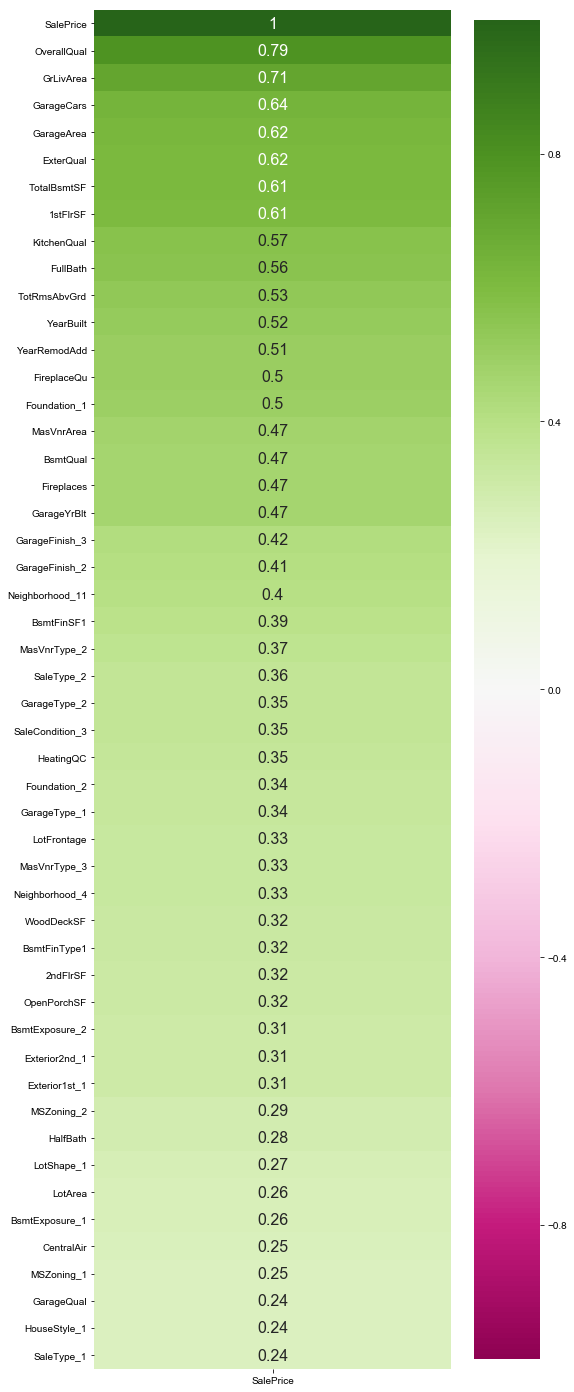

In [43]:
# Concat the Y
obj_tr_nw = pd.concat([Train_Set,y_tr],axis =1)
obj_tr_nw.shape

corr_new_train=obj_tr_nw.corr().abs()
plt.figure(figsize=(8,25))
# Top 40 correlations to price in descending order
top_40 = corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(50)
sns.heatmap(top_40,annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sns.set(font_scale=2)

**Lets check the Correlation of independent variables with each other.**


In [44]:
# find the absolute covariances 
corrmatrix =obj_tr_nw.corr().abs()

# Create a mask for cov matrix and plot the masp
mask = np.triu(np.ones_like(corrmatrix,dtype=bool))
x_y_msk = corrmatrix.mask(mask)
# f, ax = plt.subplots(figsize=(20,15))
# sns.heatmap(x_y_msk, vmax=0.8, square=True)
# plt.title('Covariance Matrix of Features before Dropping',fontsize =16)

#Create a list of all correlated features > 0.90
drop_vars = [c for c in x_y_msk.columns if any(x_y_msk[c] > 0.90)]

# rankin highest correlated pairs
s = corrmatrix.unstack()
so = s.sort_values(ascending=False)
print('Top correlated Variables over 90%')
print(so[237:262])

Top correlated Variables over 90%
SaleType_2       SaleCondition_3    0.986819
SaleCondition_3  SaleType_2         0.986819
Exterior2nd_1    Exterior1st_1      0.977525
Exterior1st_1    Exterior2nd_1      0.977525
Exterior2nd_7    Exterior1st_7      0.974171
Exterior1st_7    Exterior2nd_7      0.974171
Exterior1st_2    Exterior2nd_2      0.973065
Exterior2nd_2    Exterior1st_2      0.973065
GarageCond       GarageFinish_4     0.971923
                 GarageType_5       0.971923
GarageType_5     GarageCond         0.971923
GarageFinish_4   GarageCond         0.971923
GarageCond       GarageQual         0.969538
GarageQual       GarageCond         0.969538
                 GarageType_5       0.969351
                 GarageFinish_4     0.969351
GarageFinish_4   GarageQual         0.969351
GarageType_5     GarageQual         0.969351
RoofStyle_1      RoofStyle_2        0.933462
RoofStyle_2      RoofStyle_1        0.933462
LotShape_2       LotShape_1         0.925959
LotShape_1       LotS

**Remove 1 of the highly correlated pairs that are also in in the 'top 50' correlation to 'SalePrice'.**

![Correlated Variables](https://lh3.google.com/u/0/d/1Ub01FQAJ6Xtu13gnpqv07qZgv9_kdPSd=k)

**For example: RoofStyle_1 is correlated with RoofStyle_2 so we remove
RoofStyle_1 since it has a smaller correlation coefficient with the target variable SalePrice**

In [ ]:
top_cov = list(top_40.index)
# 1 of pair 2 be removed
corr_pair = {'SalePrice','SaleCondition_3','Exterior1st_1','GarageFinish_4','GarageType_5','LotShape_2' } 
top_cov = [ele for ele in top_cov if ele not in corr_pair] 

In [ ]:
# Select only the Top rated features X
Train_Set = Train_Set.dropna(axis=0,how='any')
Train_Set = Train_Set[top_cov]

# Giving credit where credit is due:Specifically for these 3 steps PCA,KNN with DBSCAN,for outlier detection> I refered to this great submission from **Tolga Kapla:** https://www.kaggle.com/darkside92/detailed-examination-for-house-price-top-10/#data


**Feature Selection-Outlier Detection**


**Prinicipal Component Analysis(PCA)**
Principal Component Analyis is a statistical procedure to convert a set of observation of possibly correlated variables into a set of values of linearly uncorrelated variables.

Data must be normalized with the since PCA is based off of the euclidian distance. I use robustscaler() normalizer since it is robust to outliers.

Text(0, 0.5, 'Explanined variance ratio for number of components')

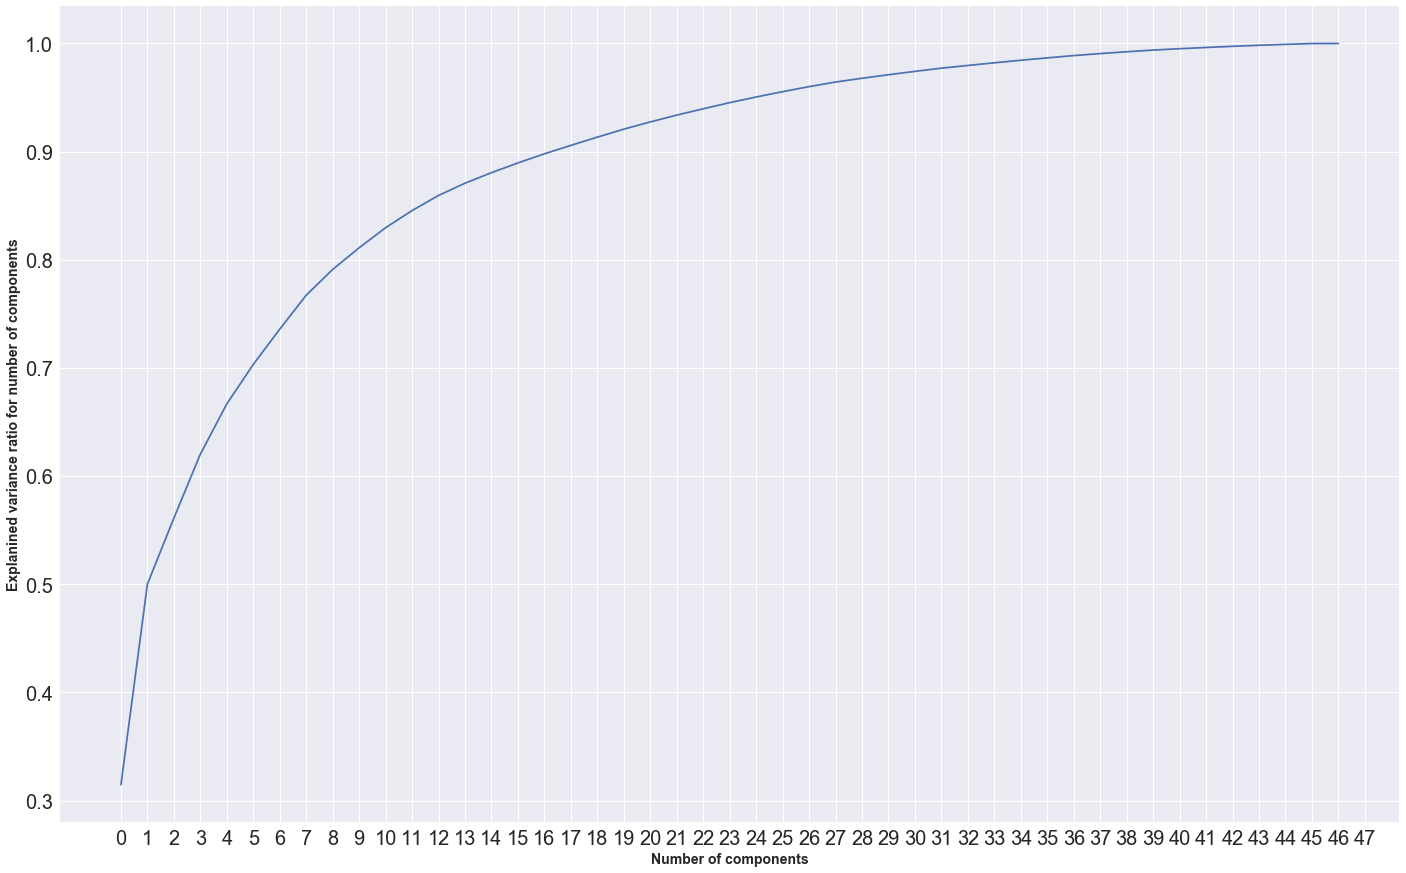

In [47]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler,RobustScaler,FunctionTransformer
from sklearn.preprocessing import StandardScaler

#Scale the data
rbst_scaler = RobustScaler()
train_std = rbst_scaler.fit_transform(Train_Set)
# train_rbst = X

pca=PCA().fit(train_std)
#pca=PCA(35).fit(X)
plt.figure(figsize=(24,15))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 48, 1))
plt.xlabel('Number of components',fontweight='bold',size=14)
plt.ylabel('Explanined variance ratio for number of components',fontweight='bold',size=14)


**Around 27 features or so explain 95% of the variance based on the magnitudes of the eigenvalues as seen below,we will stick with these 25**

In [48]:
pca_50 = PCA(27)
train_pca=pca_50.fit_transform(train_std)
train_pca.shape

# Variance of the 22 principal components
Var_count = list(pca_50.explained_variance_ratio_)
print(sum(Var_count))
print(Var_count)

0.9600961676340807
[0.31470668658397377, 0.1855069323947967, 0.06100501945679113, 0.05909983761410048, 0.0465007711113141, 0.036450971332242524, 0.03262961082503043, 0.03137268366547596, 0.023842058930282045, 0.020000610425541843, 0.018547114248295582, 0.01584348721438292, 0.01398651305199801, 0.01132196333357961, 0.009741636560967819, 0.008997773848083934, 0.008436824993894278, 0.00778700485401614, 0.007617867512635437, 0.007381041470851944, 0.006673974637810736, 0.00630814823156475, 0.005847648343170654, 0.0056628884303271815, 0.005235948367946796, 0.004934538762622759, 0.004656611432383085]


**KNN**

**Determine the “knee”, which corresponds to the optimal epsilon parameter.A knee corresponds to a threshold where a sharp change occurs along the k-distance curve. More simply,the Knee indicates where is a sizeable gap in euclidian distance from a few datapoints(the outliers) to the majority of the datapoints.**

https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

Text(0, 0.5, 'Normalized Distance away from nearest neighbour')

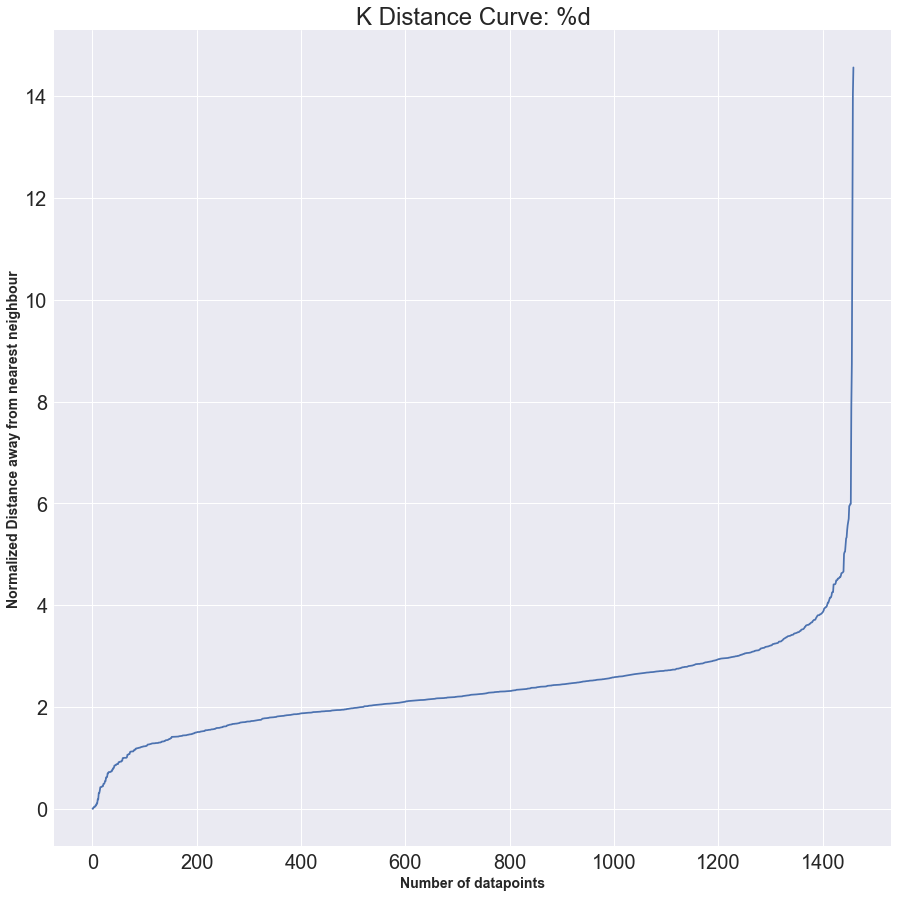

In [50]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)

nbrs = neigh.fit(train_std)
distances, indices = nbrs.kneighbors(train_std)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,15))
plt.plot(distances)
plt.title('K Distance Curve)
plt.xlabel('Number of datapoints',fontweight='bold',size=14)
plt.ylabel('Normalized Distance away from nearest neighbour',fontweight='bold',size=14)
# plt.yticks(np.arange(0, 8, 0.5))

**From the KNN we see the sharp increase at around 4 units epsilon.This indicates where is a sizeable gap in euclidian distance from a few datapoints to the majority of datapoints,for more on DBScab:**
DBSCAN 
https://ieeexplore.ieee.org/document/8342664

**DBScan**

It is a density-based clusering algorithm.The key idea is that for each point of a cluster, the neighborhood of a given radius has to contain at least a minimum number of points

The two main advantages of DBSCAN for our purposes is:
* DBSCAN can identify outliers
* DBSCAN can find any shape of clusters. The cluster doesn’t have to be circular.

https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#advantages

In [53]:
from sklearn.cluster import DBSCAN
# Initialize the DB Scan
dbscan = DBSCAN(eps=4, min_samples= 20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

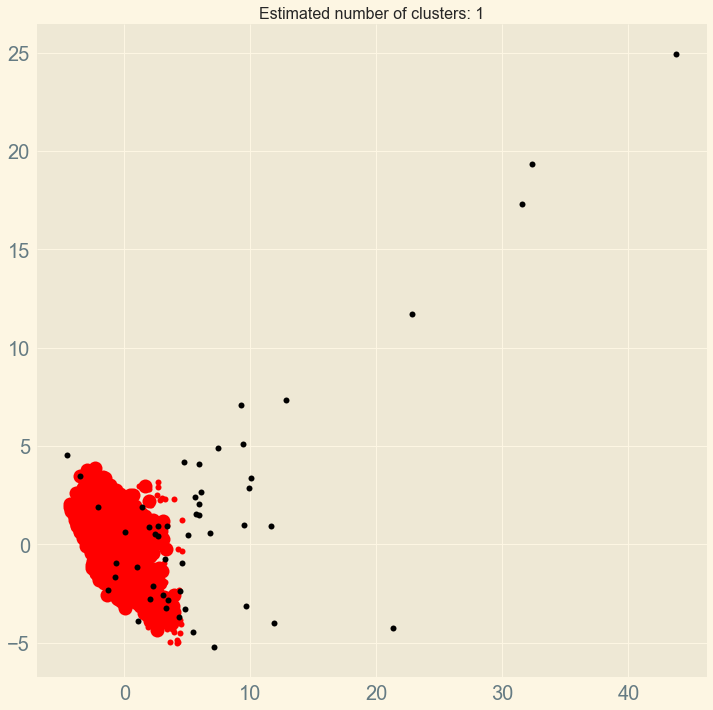

In [55]:
plt.style.use('Solarize_Light2')
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# label these outliers above as -1
labels=pd.DataFrame(labels,columns=['Classes'])
print(labels[labels['Classes']==-1])

**Feature Selection- Get Rid of the Outliers**

In [57]:
# Concat outliers with Train Set
X=pd.concat([Train_Set,labels],axis=1)

X = X.dropna(axis=0,how='any')

# located outlier indicies
out_inx = list(X[X.Classes==-1].index)
(out_inx)

#Drop the outliers
X.drop(out_inx,axis=0,inplace=True)

In [58]:
# Merge X and Y
x_y = pd.concat([X, y_tr],axis =1)

# Remove Nans and Infinitis
x_y = x_y[~x_y.isin([np.nan, np.inf, -np.inf]).any(1)]

# Drop the classes column column
x_y.drop(['Classes'],axis=1,inplace=True)
x_y.shape

(1408, 48)

Train Test Split

In [59]:
Y = x_y['SalePrice']

X = x_y.drop(['SalePrice'],axis=1)

# Train,Test Split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.1, random_state=0)

Intersection of Variable Names for functions below Recall:
* top_cov
* numeric_after
* skew_over_1

In [66]:
# Intersection Function needed 
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3


# The list of variables to unskew the first time with Powertransformer
fix_1st = intersection(top_cov, numeric_after)

# The list of variables to unskew the second time with MinMax and ExperimentalTransformer
fix_2st = intersection(top_cov, skew_over_1)

**Model Selection**

Now I bring back up the topic of **Data Leakage**. This is the reason why I merged and separated the original Train and Test sets a few times. I wanted to do the 1 hot encoding,removing null values etc. for both datasets combined and these procedure will not cause bais/overfit.The **DATA TRANSFORMATIONS** however across the combinded datasets would cause data leakage as it give information to the test set.

In order to save time I could just separate the data before but I did not do this because I wanted to do **Cross validation**.Doing Transformations before cross validation is an easy way to cause Data Leakage.It is definately more time consuming but because this is a project to learn and there is noo time crunch,I thought I would take extra time to try it this way and improve my modeling skills.

**Some more notes on Data Leakage:**

*'Here we see the intrinsic problem of applying a transformer and an estimator separately where the parameters for estimator (SVM) are determined using GridSearchCV . The scaled features used for cross-validation is separated into test and train fold but the test fold already contains the info about training set as the whole training set (X_train) was used for standardization. In a simpler note when SVC.fit() is done using cross-validation the features already include info from the test-fold as StandardScaler.fit() was done on the whole training set.'*
https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

https://machinelearningmastery.com/data-leakage-machine-learning/

**Lasso Regression**

In [67]:
# Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer


#Create the list of column transformers
Skew_Transf = [('pow_trans', PowerTransformer(method='yeo-johnson'), fix_1st),
                ("MinMax", MinMaxScaler(), fix_2st),
                  ('custom_trans',ExperimentalTransformer_2(intersection(top_cov, skew_over_1)),fix_2st )]


# Apply to the Column Transformer function
col_tran = ColumnTransformer(transformers=Skew_Transf,remainder='passthrough')

# Set the pipeline function for the independent variables
pipeline = Pipeline(steps=[('prep',col_tran),('Lasso', Lasso())])

# Initialize the trans reg to rescale the target 
model = TransformedTargetRegressor(regressor=pipeline,func=np.log1p,inverse_func=np.expm1) #, transformer = transformer

# Tuning Parameters
parameters={'regressor__Lasso__alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,10,100,300,500,700,1000,10000]}

cv = KFold(n_splits=5, random_state=1, shuffle=True)

Lasso_reg_MSE=GridSearchCV(model,parameters, scoring=['neg_mean_squared_error'], cv=cv,refit='neg_mean_squared_error')

In [ ]:
#Lasso_reg_MSE.get_params().keys()
Lasso_reg_MSE.fit(X_train, y_train)

In [69]:
yhat = Lasso_reg_MSE.predict(X_test)
#print(Lasso_reg_MSE.best_params_)

print('Test MSE',mean_squared_error(np.log1p(y_test), np.log1p(yhat)))
print('Test r2',r2_score(np.log1p(y_test), np.log1p(yhat)))

# Lets output 15 values to compare
pred_15 = pd.DataFrame((yhat)[0:15],columns=['Predicted SalePrice'])
pred_15.reset_index(drop=True, inplace=True)

obs_15 = pd.DataFrame((y_test)[0:15])
obs_15.reset_index(drop=True, inplace=True)

lasso_y = pd.concat([obs_15,pred_15],axis=1,join='inner')
lasso_y


Test MSE 0.012774173958009932
Test r2 0.9142466787940275


,SalePrice,Predicted SalePrice
0,78000,88862.113912
1,261500,240897.417761
2,117000,150344.273117
3,60000,49874.710090
4,169000,178395.680703
5,109500,93273.902026
6,156000,136924.799305
7,402861,409666.373577
8,104000,116088.018738
9,115000,131454.729977


**Ridge Regression**

In [70]:
#Create the list of column transformers
Skew_Transf = [('pow_trans', PowerTransformer(method='yeo-johnson'), fix_1st),
                ("MinMax", MinMaxScaler(), fix_2st),
                  ('custom_trans',ExperimentalTransformer_2(intersection(top_cov, skew_over_1)),fix_2st)]


# Apply to the Column Transformer function
col_tran = ColumnTransformer(transformers=Skew_Transf,remainder='passthrough')

# Set the pipeline function for the independent variables
pipeline = Pipeline(steps=[('prep',col_tran),('Ridge', Ridge())])

# Initialize the trans reg to rescale the target 
modelrd = TransformedTargetRegressor(regressor=pipeline,func=np.log1p,inverse_func=np.expm1) 

# Ridge Parameters
parameters={'regressor__Ridge__alpha':[1e-15,1e-10,1e-8,1e-3,1,5,10,20,30,40,50,70,100,200,400,700,1000,100000]}

#Initialize the cross validation
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# Gradserach for optimal parameters
ridge_reg_MSE=GridSearchCV(modelrd,parameters,scoring=['neg_mean_squared_error'],cv=cv,refit='neg_mean_squared_error')

In [ ]:
# fit the model
ridge_reg_MSE.fit(X_train,y_train)
#ridge_reg_MSE.get_params().keys()

In [72]:
#predict the y's
yhatrd = ridge_reg_MSE.predict(X_test)

print('Test MSE',mean_squared_error(np.log1p(y_test), np.log1p(yhatrd)))
print('Test r2',r2_score(np.log1p(y_test), np.log1p(yhatrd)))

# Lets output 15 values to compare
pred_15 = pd.DataFrame((yhatrd)[0:15],columns=['Predicted SalePrice'])
pred_15.reset_index(drop=True, inplace=True)

obs_15 = pd.DataFrame((y_test)[0:15])
obs_15.reset_index(drop=True, inplace=True)

lasso_y = pd.concat([obs_15,pred_15],axis=1,join='inner')
lasso_y


Test MSE 0.01277417395801077
Test r2 0.914246678794022


,SalePrice,Predicted SalePrice
0,78000,88862.113912
1,261500,240897.417761
2,117000,150344.273117
3,60000,49874.710090
4,169000,178395.680703
5,109500,93273.902026
6,156000,136924.799305
7,402861,409666.373577
8,104000,116088.018738
9,115000,131454.729977


**XGBoost**

In [86]:
#Create the list of column transformers
Skew_Transf = [('pow_trans', PowerTransformer(method='yeo-johnson'), fix_1st),
                ("MinMax", MinMaxScaler(), fix_2st),
                  ('custom_trans',ExperimentalTransformer_2(intersection(top_cov, skew_over_1)),fix_2st)]


# Apply to the Column Transformer function
col_tran = ColumnTransformer(transformers=Skew_Transf,remainder='passthrough')

# Set the pipeline function for the independent variables
pipeline = Pipeline(steps=[('prep',col_tran),('xgb', xgb.XGBRegressor())])

# Initialize the trans reg to rescale the target 
modelxgb = TransformedTargetRegressor(regressor=pipeline,func=np.log1p,inverse_func=np.expm1) 
parameters = {'regressor__xgb__learning__rate': [0.01,0.05, 0.07],
              'regressor__xgb__max__depth': [2,3,4,5, 6, 7],
              'regressor__xgb__n__estimators': [100,200]}

#Initialize the cross validation
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# Gradserach for optimal parameters
XGB_Grid =GridSearchCV(modelxgb,parameters,scoring=['neg_mean_squared_error'],cv=cv,refit='neg_mean_squared_error')

In [79]:
modelxgb.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__memory', 'regressor__steps', 'regressor__verbose', 'regressor__prep', 'regressor__xgb', 'regressor__prep__n_jobs', 'regressor__prep__remainder', 'regressor__prep__sparse_threshold', 'regressor__prep__transformer_weights', 'regressor__prep__transformers', 'regressor__prep__verbose', 'regressor__prep__pow_trans', 'regressor__prep__MinMax', 'regressor__prep__custom_trans', 'regressor__prep__pow_trans__copy', 'regressor__prep__pow_trans__method', 'regressor__prep__pow_trans__standardize', 'regressor__prep__MinMax__copy', 'regressor__prep__MinMax__feature_range', 'regressor__prep__custom_trans__feature_name', 'regressor__xgb__objective', 'regressor__xgb__base_score', 'regressor__xgb__booster', 'regressor__xgb__colsample_bylevel', 'regressor__xgb__colsample_bynode', 'regressor__xgb__colsample_bytree', 'regressor__xgb__gamma', 'regressor__xgb__gpu_id', 'regressor__xgb__importance_type', 'regressor__xgb__interaction_constraints', 

In [ ]:
#modelxgb.get_params().keys()
XGB_Grid.fit(X_train,y_train)

In [89]:
pred_XG = XGB_Grid.predict(X_test)

print('Test MSE',mean_squared_error(np.log1p(y_test), np.log1p(pred_XG)))
print('Test r2',r2_score(np.log1p(y_test), np.log1p(pred_XG)))

#inverse transform the Y values
# Lets output 15 values to compare
pred_15 = pd.DataFrame((pred_XG)[0:15],columns=['Predicted SalePrice'])
pred_15.reset_index(drop=True, inplace=True)

obs_15 = pd.DataFrame((y_test)[0:15])
obs_15.reset_index(drop=True, inplace=True)

lasso_y = pd.concat([obs_15,pred_15],axis=1,join='inner')
lasso_y


Test MSE 0.01864116260397962
Test r2 0.8748614501660614


,SalePrice,Predicted SalePrice
0,78000,75269.578125
1,261500,237447.156250
2,117000,141593.218750
3,60000,37399.519531
4,169000,169205.734375
5,109500,101666.000000
6,156000,131918.796875
7,402861,437894.093750
8,104000,121006.929688
9,115000,149955.906250


**Recursive Feature Elimination-RFE**

In [90]:
# Linear model with Recurrsive Feature Elimination

#Create the list of column transformers
Skew_Transf = [('pow_trans', PowerTransformer(method='yeo-johnson'), fix_1st),
                ("MinMax", MinMaxScaler(), fix_2st),
                  ('custom_trans',ExperimentalTransformer_2(intersection(top_cov, skew_over_1)),fix_2st)]


# Make the pipeline
pipeline = Pipeline([('pow_trans',PowerTransformer(method='yeo-johnson')),
                     ('s', RFE(estimator = LinearRegression())),
                      ('m',LinearRegression())])

# Transform the SalePrice
fmodel = TransformedTargetRegressor(regressor=pipeline,func=np.log1p,inverse_func=np.expm1) 

parameters={'regressor__s__n_features_to_select': [1,2,3,4,5,6,7,8,9,10,15,16,17,18,20,25,26,27,28,29,30,35,40]}

cv = KFold(n_splits=5, random_state=1, shuffle=True)

RFE_MS = GridSearchCV(fmodel,parameters,scoring=['neg_mean_squared_error'],cv=cv,refit='neg_mean_squared_error',verbose=1)

In [ ]:
# RFE_MS.get_params().keys() 
RFE_MS.fit(X_train,y_train)

In [94]:
y_predrfe = RFE_MS.predict(X_test)

print('Test MSE',mean_squared_error(np.log1p(y_test), np.log1p(y_predrfe)))
print('Test r2',r2_score(np.log1p(y_test), np.log1p(y_predrfe)))
print(RFE_MS.best_params_)

# Lets output 15 values to compare
pred_15 = pd.DataFrame((y_predrfe)[0:15],columns=['Predicted SalePrice'])
pred_15.reset_index(drop=True, inplace=True)

obs_15 = pd.DataFrame((y_test)[0:15])
obs_15.reset_index(drop=True, inplace=True)

lasso_y = pd.concat([obs_15,pred_15],axis=1,join='inner')
lasso_y

Test MSE 0.012498237557317838
Test r2 0.9160990461469969
{'regressor__s__n_features_to_select': 40}


,SalePrice,Predicted SalePrice
0,78000,91151.627370
1,261500,256473.828415
2,117000,146133.852558
3,60000,49420.889014
4,169000,174169.199271
5,109500,96714.905978
6,156000,137894.185626
7,402861,418620.152463
8,104000,110800.019835
9,115000,131988.444457
